<img src="Trend and topic detection in scientific papers4.png" width="900" height="900" align="center"/>

# I- Introduction
---
In this **Text Mining project**, we will identify which topic is discussed in **scientific papers**. In particular, we will use **Latent Dirichlet Allocation (LDA)**, an unsupervised machine learning algorithm. And we will apply LDA to convert a set of scientific papers to a set of topics and visualise them using **pyLDAvis**, a Python library for interactive topic model visualization. Once the topics are identified, will map the most important topic to each document and store it as a DataFrame that we will transform later to a **Time Series** that we use to extract **trending topics** with the help of **Moda**, a models and evaluation framework for **trending topics detection**.
<br>

Scientific paper topic detection helps us discover hidden semantic structures in a paper and to learn topic representations of papers in a corpus.

# II- Steps for topic detection : 
---
#### 1) The Input :
First we have to predict the number of topics in advance.
<br>
Corpus --> set of documents.
<br>
Document --> distribution over topics.
<br>
Topic --> distribution over words.
<br>
**Input** = Set of unlabeled texts (press_scientific_papers.csv) (language = english)
<br>
#### 2) Description of the dataset  :
The dataset that we will use in this project is called "Science to Science Press and Paper Datasets" downloaded from kaggle.
<br>
This is the dataset that we think it contains diverse topics about science, but unfortunately it does not contrain a **date** column that we will use later as index for our time series, so we will add an "Imaginary" date column just for demonstration. 
<br>

#### 3) Loading the data : 

In [ ]:
import pandas as pd
import os
papers = pd.read_csv('press_scientific_papers.csv')
papers.head()

,press_id,press_headline,press_org,press_text
0,pt_2a3e9,What's in a name? Shifting meanings of biologi...,Pensoft Publishers,Standardized scientific names for biological s...
1,pt_2756e,Two new mechanisms for herbicide resistance fo...,University of Illinois College of Agricultural...,"Palmer amaranth is a nightmare of a weed, caus..."
2,pt_5ca64,Speech means using both sides of brain,New York University,"We use both sides of our brain for speech, a f..."
3,pt_65994,"Dormant copies of HIV mostly defective, new st...",Johns Hopkins Medicine,"After fully sequencing the latent HIV ""proviru..."
4,pt_c1bd0,Common sedatives linked to increased risk of p...,Canadian Medical Association Journal,Commonly used sedatives called benzodiazepines...


#### 4) Removing unnecessary columns from the dataframe and extracting the "title" column : 

In [ ]:
n = 30 # we used n to reduce the size of the dataset because if we don't, it will take forever, we will restrict our demo on a limited number of rows n.
papers = papers.drop(columns = ['press_id', 'press_org'], axis = 1) # removing unecessary columns
title = papers['press_headline'].tolist() # extracting the title column and transforming it to a list.
title = title[:n] # reducing the number of rows of the title column
title

["What's in a name? Shifting meanings of biological names",
 'Two new mechanisms for herbicide resistance found in Palmer amaranth',
 'Speech means using both sides of brain',
 'Dormant copies of HIV mostly defective, new study shows',
 "Common sedatives linked to increased risk of pneumonia in people with Alzheimer's disease",
 'Metabolism harnessed to reverse aggressiveness in leukemia',
 'Most painful days of your life - school desks and chronic back pain',
 'Elucidating the Chara genome: Implications for emergence of land plants in Paleozoic era',
 'The beating heart of solar energy',
 'First-ever study shows e-cigarettes cause damage to gum tissue',
 'Study identifies most common, costly reasons for mental health hospitalizations for kids',
 'Photonics advances allow us to be seen across the universe, with major implications for search for extraterrestrial intelligence',
 "Link between microbiome in the gut, Parkinson's discovered",
 'Artificial sensor mimics human sense of touch'

#### 5) Removing punctuation from the texts and reducing the number of texts :  (Preprocessing)

In [ ]:
import re # regular expression library
papers['press_text_processed'] = papers['press_text'].map(lambda x: re.sub('[,.!?+-1234567890]', '', x)) # we remove punctuation and digits
papers['press_text_processed'] = papers['press_text_processed'].map(lambda x: x.lower()) # we convert the words to lowercase
y = papers['press_text_processed'][:n] # reducing the number of processed texts of the dataset
print(y)

0     standardized scientific names for biological s...
1     palmer amaranth is a nightmare of a weed causi...
2     we use both sides of our brain for speech a fi...
3     after fully sequencing the latent hiv "proviru...
4     commonly used sedatives called benzodiazepines...
5     university of georgia researchers with colleag...
6     undersize school chairs low desks and overweig...
7     land plants dominate terrestrial flora and our...
8     the notion of using solar cells placed under t...
9     a university of rochester medical center study...
10    nearly one in  hospitalized children have a pr...
11    looking up at the night sky  expansive and see...
12    there is growing evidence showing a connection...
13    a team of researchers have developed an artifi...
14    traumatic spinal cord injury (sci) is a devast...
15    new research shows how two drastically differe...
16    an aalto university study has provided new evi...
17    a study led by researchers at the universi

**bold text**#### 6) A Word Cloud ! : 
To verify whether the preprocessing happened correctly, we’ll make a word cloud using the **wordcloud package** to get a visual representation of most common words. It is key to understanding the data and ensuring we are on the right track, and if any more preprocessing is necessary before training the model.

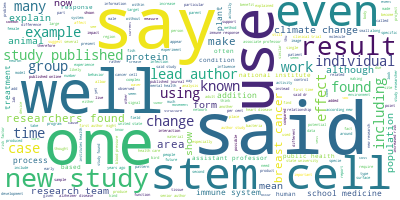

In [ ]:
from wordcloud import WordCloud # importing the wordcloud library
long_string = ','.join(list(papers['press_text_processed'].values)) # we join the different processed texts together
wordcloud = WordCloud(background_color="white", max_words = 5000, contour_width = 5, contour_color = 'steelblue') # we create a WordCloud object
wordcloud.generate(long_string) # generating the word cloud
wordcloud.to_image() # and finally visualizing the word cloud

#### 6) Preparing text of LDA analysis : 
Next, let’s work to transform the textual data in a format that will serve as an input for training **LDA** model. We start by converting the documents into a simple vector representation (**Bag of Words : BOW**). Next, we will convert a list of titles into lists of vectors, all with length equal to the vocabulary.
<br> 
We’ll then plot the ten most frequent words based on the outcome of this operation (the list of document vectors). As a check, these words should also occur in the **word cloud**.

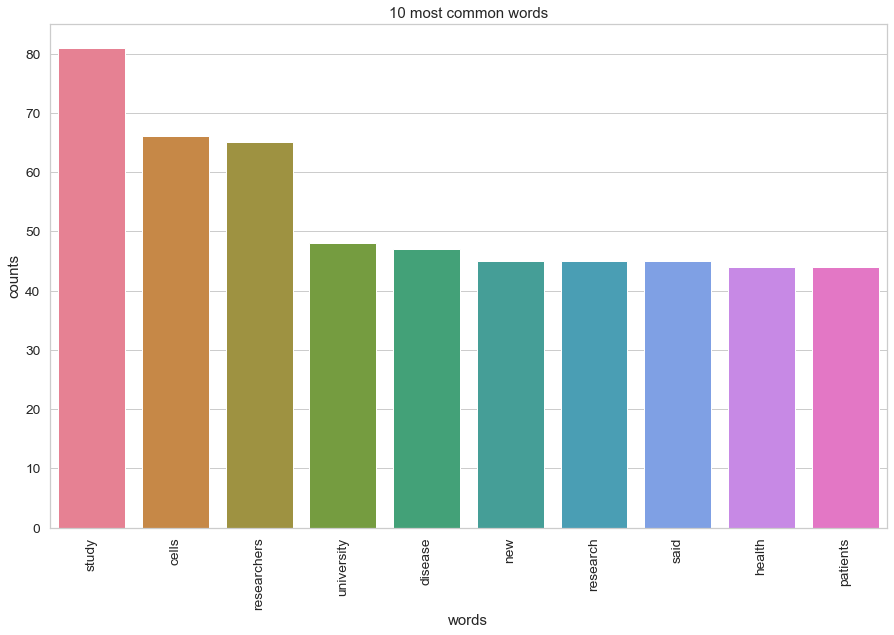

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer # loading the library with the CountVectorizer method
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from gensim import corpora
sns.set_style('whitegrid')
%matplotlib inline
# Helper function
def plot_10_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts += t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key = lambda x:x[1], reverse = True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize = (15, 15 / 1.6180))
    plt.subplot(title = '10 most common words')
    sns.set_context("notebook", font_scale = 1.25, rc = {"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette = 'husl')
    plt.xticks(x_pos, words, rotation = 90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()
######################################################################################
######################################################################################
######################################################################################
######################################################################################
count_vectorizer = CountVectorizer(stop_words = 'english') # initialising the count vectorizer with the english stop words
vocab_dictionary_learned = count_vectorizer.fit(y) # this will learn a vocabulary dictionary of all tokens in the processed texts
count_data1 = count_vectorizer.fit_transform(y) # fitting and transform the processed texts : this will learn the vocabulary and return a document_term matrix
features = count_vectorizer.get_feature_names() # this will give us the list of learned features
df = pd.DataFrame(data = count_data1.toarray(),index = title,columns = features) # this is the document-term matrix with feautres added as columns and documents added as index
######################################################################################
######################################################################################
######################################################################################
######################################################################################
plot_10_most_common_words(count_data1, count_vectorizer) # visualising the 10 most common words in the whole dataset

Now we need to **adapt** our document-term matrix (count_data1) for **LDA** and **extract the dictionary learned from the processed texts**


In [ ]:
import scipy
from gensim import matutils, models
count_data = count_data1.transpose() # sparse2corpus function needs the transpose of the sparse (document-term) matrix: so a term-document matrix !
corpus = matutils.Sparse2Corpus(count_data) # this will convert the term_document matrix into a streaming gensim corpus : corpus.sparse will give us exactly count_data
dictionary = dict((v, k) for k, v in vocab_dictionary_learned.vocabulary_.items()) # creating the vocabulary dictionary (including the locations of the terms) from the learned vocabulary dictionary
dictionary

{2878: 'standardized',
 2685: 'scientific',
 1996: 'names',
 350: 'biological',
 2848: 'species',
 3209: 'use',
 2014: 'nearly',
 3329: 'years',
 1323: 'global',
 349: 'biodiversity',
 777: 'databases',
 1357: 'grow',
 801: 'deficiencies',
 962: 'duplication',
 3227: 'various',
 1877: 'meanings',
 2082: 'obvious',
 2035: 'new',
 2933: 'study',
 2418: 'published',
 2106: 'openaccess',
 1651: 'journal',
 3343: 'zookeys',
 1135: 'explains',
 273: 'avibase',
 1149: 'extensive',
 2102: 'online',
 776: 'database',
 359: 'birds',
 5: 'able',
 2946: 'successfully',
 74: 'address',
 1630: 'issues',
 2516: 'related',
 1982: 'multiplicity',
 2123: 'organize',
 808: 'definitions',
 3195: 'unprecedented',
 2671: 'scale',
 476: 'centuries',
 352: 'biologists',
 2528: 'relied',
 2007: 'natural',
 3313: 'world',
 598: 'communicate',
 579: 'colleagues',
 1281: 'gallinula',
 514: 'chloropus',
 3177: 'understood',
 3186: 'universally',
 2496: 'refer',
 177: 'animal',
 1051: 'englishspeakers',
 596: 'comm

#### 7) LDA model training : 

Now that we have the **corpus** (gensim-adapted document-term matrix) and the **dictionary** (terms and their location), we need to specify two other parameters : **the number of topics** and **the number of passes**. 

In [ ]:
num_topics = 5
num_passes = 15

Now let's ask **LDA** to find the **topics** and print them : 

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation as LDA
ldae = models.LdaModel(corpus = corpus, id2word = dictionary, num_topics = num_topics, passes = num_passes) # creating and fitting the LDA model
lda = LDA(n_components=num_topics) # another method to fit the lda model, but we will need it to visualise the identified topics
ldax = lda.fit(count_data1) # another method to fit the lda model, but we will need it to visualise the identified topics
print("Topics found via LDA :")
ldae.print_topics() # Print the topics found by the LDA model

Topics found via LDA :


[(0,
  '0.015*"cells" + 0.007*"said" + 0.007*"leukemia" + 0.007*"naltrexone" + 0.007*"research" + 0.006*"alcohol" + 0.006*"patients" + 0.006*"researchers" + 0.006*"disease" + 0.006*"lung"'),
 (1,
  '0.015*"species" + 0.010*"water" + 0.009*"bees" + 0.008*"nicotine" + 0.007*"frog" + 0.007*"frogs" + 0.006*"infected" + 0.005*"native" + 0.005*"invasive" + 0.004*"university"'),
 (2,
  '0.010*"land" + 0.010*"plants" + 0.008*"ocean" + 0.007*"coast" + 0.006*"taxonomic" + 0.006*"names" + 0.006*"west" + 0.006*"scientific" + 0.005*"chara" + 0.005*"genome"'),
 (3,
  '0.011*"study" + 0.010*"health" + 0.006*"children" + 0.006*"researchers" + 0.006*"risk" + 0.005*"cells" + 0.005*"said" + 0.005*"parkinson" + 0.004*"disease" + 0.004*"new"'),
 (4,
  '0.010*"mmp" + 0.009*"says" + 0.007*"researchers" + 0.007*"proviruses" + 0.006*"patients" + 0.006*"speech" + 0.006*"time" + 0.006*"new" + 0.005*"brain" + 0.005*"study"')]

**bold text**#### 8) Visualising identified topics  :
Now let us see the results using pyLDAvis
#### <font color=red>! Note :</font>
For a specific number of topics we have to change the name of the file to ldavis_prepared_specific_number_of_topics.

In [ ]:
from pyLDAvis import sklearn as sklearn_lda
import pickle 
import pyLDAvis
import os
pyLDAvis.enable_notebook()
for file in os.listdir("./"):
    if file.startswith("ldavis_prepared_") and not file.endswith("html"):
        name = file
if name != ('ldavis_prepared_'+ str(num_topics)) : 
    os.rename(name, 'ldavis_prepared_'+ str(num_topics))
LDAvis_data_filepath = os.path.join('./ldavis_prepared_'+ str(num_topics))
LDAvis_prepared = sklearn_lda.prepare(ldax, count_data1, count_vectorizer)
if os.path.getsize(LDAvis_data_filepath) > 0:
    with open(LDAvis_data_filepath) as f:
          pickle.dump(LDAvis_prepared, f)
if os.path.getsize(LDAvis_data_filepath) > 0:      
     with open(LDAvis_data_filepath) as f:
            LDAvis_prepared = pickle.load(f) # loading the pre-prepared pyLDAvis data
pyLDAvis.save_html(LDAvis_prepared, './ldavis_prepared_'+ str(num_topics) +'.html')
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.088396 -0.076691       1        1  24.830805
0     -0.046383  0.132693       2        1  24.454037
1      0.004515 -0.085790       3        1  17.565532
4      0.174926  0.004979       4        1  17.307833
2     -0.044662  0.024808       5        1  15.841792, topic_info=     Category       Freq        Term      Total  loglift  logprob
2267  Default  23.000000      plants  23.000000  30.0000  30.0000
1701  Default  19.000000        land  19.000000  29.0000  29.0000
1944  Default  18.000000         mmp  18.000000  28.0000  28.0000
467   Default  50.000000       cells  50.000000  27.0000  27.0000
2086  Default  15.000000       ocean  15.000000  26.0000  26.0000
...       ...        ...         ...        ...      ...      ...
2933   Topic5   7.051419       study  60.503030  -0.3069  -5.3587
2591   Topic5   4.977840     results  20.842449   0.4105  -5.7069
881    Topic5   4.286484   different  15.217645   0.5755  -5.8564
3188   Topic5   4.286243  university  36.640516  -0.3032  -5.8565
1760   Topic5   3.595216      likely   8.852830   0.9414  -6.0323

[295 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
0         2  0.782454          aalto
39        3  0.933688  acidification
55        1  0.092485       activity
55        2  0.184970       activity
55        3  0.369941       activity
...     ...       ...            ...
3271      3  0.146730            way
3271      5  0.146730            way
3288      3  0.988837           west
3337      5  0.712405           yune
3341      2  0.782454          zhang

[444 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 2, 5, 3])

#### 9) Identifying topics in each document (text) :
Let us see which topics each document contains

In [ ]:
corpus_transformed = ldae[corpus]
topic_text = list(zip([a for [(a,b)] in corpus_transformed], title))
topic_text

[(2, "What's in a name? Shifting meanings of biological names"),
 (4, 'Two new mechanisms for herbicide resistance found in Palmer amaranth'),
 (4, 'Speech means using both sides of brain'),
 (4, 'Dormant copies of HIV mostly defective, new study shows'),
 (3,
  "Common sedatives linked to increased risk of pneumonia in people with Alzheimer's disease"),
 (0, 'Metabolism harnessed to reverse aggressiveness in leukemia'),
 (3, 'Most painful days of your life - school desks and chronic back pain'),
 (2,
  'Elucidating the Chara genome: Implications for emergence of land plants in Paleozoic era'),
 (0, 'The beating heart of solar energy'),
 (3, 'First-ever study shows e-cigarettes cause damage to gum tissue'),
 (3,
  'Study identifies most common, costly reasons for mental health hospitalizations for kids'),
 (3,
  'Photonics advances allow us to be seen across the universe, with major implications for search for extraterrestrial intelligence'),
 (3, "Link between microbiome in the gut, P

**Now Let us see the result in a dataframe :**

In [ ]:
topic_text_df = pd.DataFrame(topic_text,columns = ['topic number', 'document title'])
topic_text_df

,topic number,document title
0,2,What's in a name? Shifting meanings of biologi...
1,4,Two new mechanisms for herbicide resistance fo...
2,4,Speech means using both sides of brain
3,4,"Dormant copies of HIV mostly defective, new st..."
4,3,Common sedatives linked to increased risk of p...
5,0,Metabolism harnessed to reverse aggressiveness...
6,3,Most painful days of your life - school desks ...
7,2,Elucidating the Chara genome: Implications for...
8,0,The beating heart of solar energy
9,3,First-ever study shows e-cigarettes cause dama...



# III- Steps for trending topics detection : 
---
#### 1) Requirements for the trend detection  :

<br>

The input in our case must be a time series, where the column is the **topic number** (since we don't have a specific name for our topics but a bunch of words to describe it) and the index must be a **date** ! therefor we must transform our dataframe to a time series using **moda** framework.
<br> 
### <font color=red>! Note :</font>
In moda package there exists two function called **raw_to_ts** that will transform our dataframe to a time series and **ts_to_range** that will create time intervals and aggregate the time and topic number and then create a count for each topic in specific period of time which is our goal !
The problem is that when we call ts_to_range function directly from the **moda package**, it shows an error saying that **pandas.TimeGrouper()** does not exist, this is because it was replaced by **pandas.Grouper()** in the latest pandas updates, so we have corrected the function **ts_to_range** and added it to **ts_to_range.py** with the name **ts_to_rangexz** file so we can call it directly from our project directory. You may want to keep that in mind when installing **moda**.  

#### 2) Adding time to the dataframe : 

<br>

Our solution uses **time series** analysis methods for how much a topic is **trending**, so far, for each document, a topic or multiple topics are extracted if found, and now the count of items per topic over time is needed ==> we need to index our topics by time ==> **time series** ! 
Unfortunately our original dataset ,which we think represents a good dataset for **scientific** papers because it contains full texts and not just titles, does not contain the notion of time, that is why we will add a column called "date" extracted from another dataset just for the sake of demo. and the we will even try the method on other datasets probably not focusing on **science**. 
<br> 

In [ ]:
x = pd.read_csv('x.csv') # a dataset that contains columns: year, month and day
x['date'] = pd.to_datetime(x[['year','month','day']]) # we combine the three columns year, month, day to a single date
x = x.drop(columns=['id','abstract','year','month','day','scites','authors','title','Unnamed: 0'], axis = 1) # we eliminate unecessary columns in the dataset
x = x[:n] # we reduce the number of rows as usual
topic_text_df['date'] = x['date'] # we add the date column to our dataframe
topic_text_df = topic_text_df.drop(columns = ['document title'], axis = 1) # we remove the title column in our dataframe as we don't need it anymore, we only need the topic number only !! 
topic_text_df 

,topic number,date
0,2,2016-03-11
1,4,2016-04-27
2,4,2016-04-08
3,4,2015-02-17
4,3,2016-01-29
5,0,2015-11-16
6,3,2015-08-26
7,2,2015-11-03
8,0,2016-06-13
9,3,2016-11-22


#### 3) Transforming our dataframe to a time series and obtaining the trending topics for a specific interval of time :   
we will transform our dataframe to a time series and we will create time intervals and aggregate the time and topic number and then create a count for each topic in specific period of time. 

In [ ]:
import moda
from ts_to_range import ts_to_rangexz # we import the function that we have corrected from our working directory
from moda.dataprep import raw_to_ts # there is no problem with the raw_to_ts module as the function in it called also raw_to_ts has no problems, so we import it directly from the package
TIME_RANGE = "1M" # we will use it to aggregate all topics in the dataframe into fixed intervals.
ts = raw_to_ts.raw_to_ts(topic_text_df) # turning the dataframe into a time series with date as index.
ranged_ts = ts_to_rangexz(ts,time_range = TIME_RANGE) # aggregating dataframe items per time and category for a fixed and given time interval and obtain the count of each topic in a time interval 
ranged_ts 

value
date       topic number       
2013-11-30 2               1.0
2013-12-31 2               0.0
2014-01-31 2               0.0
2014-02-28 2               0.0
2014-03-31 2               0.0
...                        ...
2016-11-30 0               1.0
           3               1.0
           4               2.0
2016-12-31 0               1.0
           4               1.0

[101 rows x 1 columns]

#### 4) Visualising the trending topics in each interval of time :   

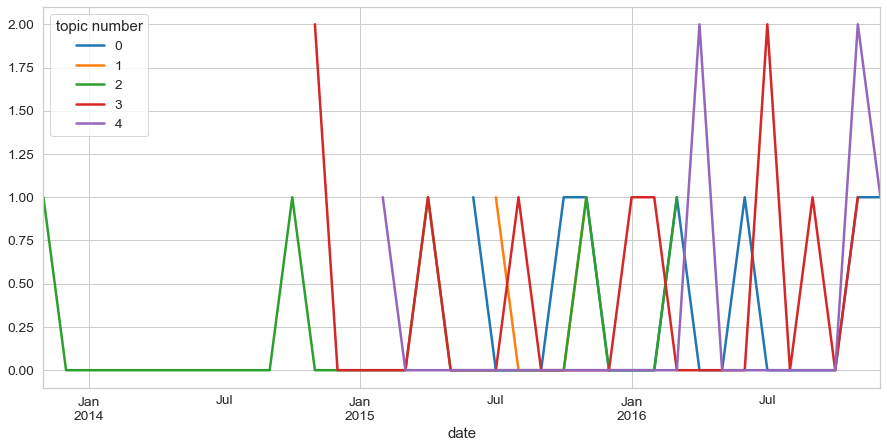

In [ ]:
fig, ax = plt.subplots(figsize = (15,7))
ranged_ts.groupby(['date','topic number']).sum()['value'].unstack().plot(ax = ax)

In [ ]:
import h5py
import numpy as np
import os

file_prefix = 'FELsource_out_';data_dir = '/content';num_run='99'
filename = os.path.join(data_dir, file_prefix + str(num_run).zfill(7) + '.h5')
f = h5py.File('/content/demo.hdf5','r')   #  put the path diretory of the generated HDF5 file

def print_name(name, obj):
    if isinstance(obj, h5py.Dataset):
        print('Dataset:', name)
    elif isinstance(obj, h5py.Group):
        print('Group:', name)

with h5py.File('/content/demo.hdf5', 'r')  as h5f: # file will be closed when we exit from WITH scope
    h5f.visititems(print_name) # print all strustures names